In [1]:
import os, struct, h5py
from scipy.io import loadmat

def is_hdf5_mat(path: str) -> bool:
    """True для .mat v7.3 (HDF5), False для старых (v5 и ниже)."""
    with open(path, "rb") as f:
        head = f.read(8)
    # HDF5 сигнатура: \x89 H D F \r \n \x1a \n
    return head.startswith(b"\x89HDF\r\n\x1a\n")

def describe_hdf5(path: str, max_children: int = 20):
    with h5py.File(path, "r") as f:
        def _walk(name, obj, level=0):
            indent = "  " * level
            if isinstance(obj, h5py.Dataset):
                print(f"{indent}- [DSET] {name} shape={obj.shape} dtype={obj.dtype}")
            elif isinstance(obj, h5py.Group):
                print(f"{indent}+ [GRP ] {name} (keys={len(obj.keys())})")
                for i, k in enumerate(obj.keys()):
                    if i >= max_children:
                        print(f"{indent}  ... ({len(obj.keys())-max_children} more)")
                        break
                    _walk(f"{name}/{k}" if name != "/" else f"/{k}", obj[k], level+1)
        _walk("/", f)

def describe_v5(path: str):
    md = loadmat(path, squeeze_me=True, struct_as_record=False)
    for k, v in md.items():
        if k.startswith("__"): 
            continue
        try:
            shape = getattr(v, "shape", None)
            dtype = getattr(v, "dtype", None)
            print(f"- {k}: type={type(v).__name__}, shape={shape}, dtype={dtype}")
        except Exception as e:
            print(f"- {k}: {type(v).__name__} (err: {e})")

In [2]:
mat_path = r"C:\MEC_ILS\mat_volumes_ILS\ILS1.mat"  # пример
describe_hdf5(mat_path)

+ [GRP ] / (keys=1)
  - [DSET] /l1 shape=(888, 1520, 1520) dtype=uint16


In [3]:
import h5py, numpy as np

mat_path = r"C:\MEC_ILS\mat_volumes_ILS\ILS1.mat"
f = h5py.File(mat_path, "r")
dset = f["l1"]  # h5py.Dataset
print("shape:", dset.shape, "dtype:", dset.dtype)  # (888, 1520, 1520), uint16

shape: (888, 1520, 1520) dtype: uint16


In [4]:
import numpy as np
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops

def is_circular_mask(img2d, tol=0.15):
    x = img2d.astype(np.float32)
    t = threshold_otsu(x)
    m = x > t
    if m.sum() < 1000: 
        return 0.0
    ys, xs = np.where(m)
    cy, cx = ys.mean(), xs.mean()
    r = np.sqrt(((ys - cy)**2 + (xs - cx)**2).mean())
    # радиусы по 4-м направлениям
    up    = int(np.argmax(m[:int(cy), int(cx)][::-1]==0))
    down  = int(np.argmax(m[int(cy):, int(cx)]==0))
    left  = int(np.argmax(m[int(cy), :int(cx)][::-1]==0))
    right = int(np.argmax(m[int(cy), int(cx):]==0))
    rays  = np.array([up, down, left, right], dtype=float)
    if (rays == 0).any(): return 0.0
    score = rays.min()/rays.max()
    return float(score)  # ближе к 1 → круглее

def guess_axes(dset):
    # кандидат 1: (Z,Y,X) → срез: dset[z, :, :]
    midz = dset.shape[0]//2
    img1 = dset[midz, :, :]
    s1 = is_circular_mask(img1)

    # кандидат 2: (Y,X,Z) → срез: dset[:, :, z]
    midz2 = dset.shape[2]//2
    img2 = dset[:, :, midz2]
    s2 = is_circular_mask(img2)

    if s1 >= s2:
        return ("ZYX", 0)  # первая ось — Z
    else:
        return ("YXZ", 2)  # третья ось — Z

axes_tag, z_axis = guess_axes(dset)
print("axes guess:", axes_tag, " z_axis index:", z_axis)

axes guess: ZYX  z_axis index: 0


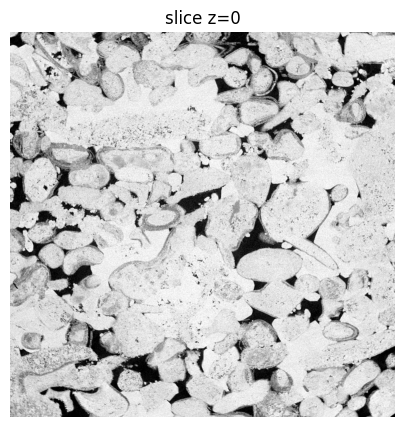

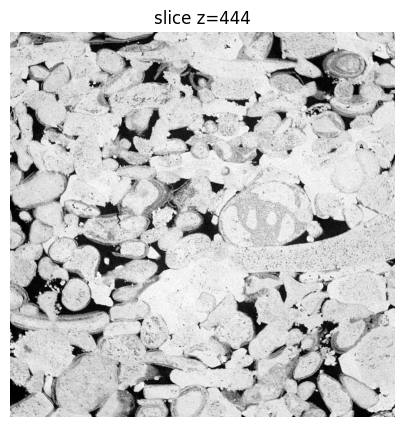

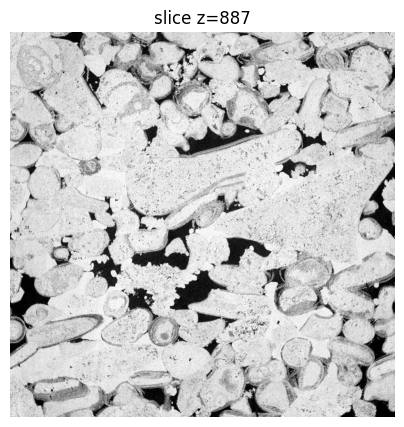

In [5]:
import matplotlib.pyplot as plt

def robust_window(img, lo=1, hi=99):
    vmin, vmax = np.percentile(img, (lo, hi))
    if vmax <= vmin: vmax = vmin + 1
    return float(vmin), float(vmax)

def show_slice(dset, z, z_axis=0):
    if z_axis == 0:
        sl = dset[z, :, :]
    elif z_axis == 2:
        sl = dset[:, :, z]
    else:
        raise ValueError("unsupported z_axis")

    sl = np.array(sl)  # вытягиваем в numpy
    vmin, vmax = robust_window(sl)
    plt.figure(figsize=(5,5))
    plt.imshow(sl, cmap="gray", vmin=vmin, vmax=vmax)
    plt.title(f"slice z={z}")
    plt.axis("off"); plt.show()

# пример показа трёх срезов
_, z_axis = guess_axes(dset)
for z in [0, dset.shape[z_axis]//2, dset.shape[z_axis]-1]:
    show_slice(dset, z, z_axis=z_axis)

In [7]:
import h5py, numpy as np
parts = [r"C:\MEC_ILS\mat_volumes_ILS\ILS1.mat", r"C:\MEC_ILS\mat_volumes_ILS\ILS2.mat", r"C:\MEC_ILS\mat_volumes_ILS\ILS3.mat", r"C:\MEC_ILS\mat_volumes_ILS\ILS4.mat"]
arrs = []
for p in parts:
    with h5py.File(p, "r") as f:
        arrs.append(f["l1"][...])   # или f["l1"][...], см. ключ
HR_full = np.concatenate(arrs, axis=2)  # если оси (Y,X,Z)
print(HR_full.shape)

KeyError: "Unable to synchronously open object (object 'l1' doesn't exist)"

In [8]:
mat_path = r"C:\MEC_ILS\mat_volumes_ILS\ILS2.mat"  # пример
describe_hdf5(mat_path)

+ [GRP ] / (keys=1)
  - [DSET] /l2 shape=(888, 1520, 1520) dtype=uint16


In [9]:
mat_path = r"C:\MEC_ILS\mat_volumes_ILS\ILS3.mat"  # пример
describe_hdf5(mat_path)

+ [GRP ] / (keys=1)
  - [DSET] /l3 shape=(888, 1520, 1520) dtype=uint16


In [10]:
import h5py, numpy as np

out_path = r"C:\MEC_ILS\mat_volumes_ILS\HR_full.h5"

# 1) сначала вычислим форму итогового массива
with h5py.File(parts[0], "r") as f0:
    d0 = get_single_dataset(f0)
    base_shape = list(d0.shape)

total = list(base_shape)
axes = "ZYX"
if axes == "YXZ":
    total[2] = sum(s[2] for s in shapes)   # суммируем Z
elif axes == "ZYX":
    total[0] = sum(s[0] for s in shapes)   # суммируем Z (если Z — первая ось)

# 2) создаём целевой файл/датасет (chunked + компрессия по желанию)
with h5py.File(out_path, "w") as fout:
    d_out = fout.create_dataset(
        "HR_full", shape=tuple(total), dtype=d0.dtype,
        chunks=True, compression="gzip", compression_opts=4
    )
    z0 = 0
    for p, shp in zip(parts, shapes):
        with h5py.File(p, "r") as f:
            d = get_single_dataset(f)
            if axes == "YXZ":
                z1 = z0 + shp[2]
                d_out[:, :, z0:z1] = d[:, :, :]
            else:  # "ZYX"
                z1 = z0 + shp[0]
                d_out[z0:z1, :, :] = d[:, :, :] if d.shape == (shp[0], shp[1], shp[2]) else d[...]
            z0 = z1
print("saved:", out_path)

NameError: name 'get_single_dataset' is not defined

In [11]:
import h5py
import numpy as np
from pathlib import Path

parts = [
    r"C:\MEC_ILS\mat_volumes_ILS\ILS1.mat",
    r"C:\MEC_ILS\mat_volumes_ILS\ILS2.mat",
    r"C:\MEC_ILS\mat_volumes_ILS\ILS3.mat",
    r"C:\MEC_ILS\mat_volumes_ILS\ILS4.mat",
]

def get_single_dataset(f: h5py.File) -> h5py.Dataset:
    """Возвращает единственный dataset в файле; если их несколько — берёт первый по имени."""
    dsets = [k for k in f.keys() if isinstance(f[k], h5py.Dataset)]
    if not dsets:
        raise KeyError("Нет HDF5 dataset-ов в файле.")
    if len(dsets) > 1:
        # при желании можно ввести приоритет по именам:
        for pref in ("l1","l2","l3","l4","HR","LR","tomo","data"):
            if pref in f:
                return f[pref]
        dsets.sort()
    return f[dsets[0]]

# читаем формы и определяем по какой оси склеивать
shapes = []
keys = []
for p in parts:
    with h5py.File(p, "r") as f:
        dset = get_single_dataset(f)
        shapes.append(dset.shape)
        keys.append(dset.name)

print("keys:", keys)
print("shapes:", shapes)

# эвристика: если первые две оси совпадают у всех, а третья отличается → concat по оси 2 (Y,X,Z)
# иначе, если последние две совпадают, а первая отличается → concat по оси 0 (Z,Y,X)
axes = None
if all(s[:2] == shapes[0][:2] for s in shapes) and len({s[2] for s in shapes}) > 1:
    concat_axis = 2
    axes = "YXZ"
elif all(s[1:] == shapes[0][1:] for s in shapes) and len({s[0] for s in shapes}) > 1:
    concat_axis = 0
    axes = "ZYX"
else:
    raise RuntimeError(f"Не могу однозначно определить ось склейки из форм: {shapes}")

# читаем полностью и склеиваем
arrs = []
for p in parts:
    with h5py.File(p, "r") as f:
        dset = get_single_dataset(f)
        arrs.append(dset[...])   # полностью в RAM (uint16)

HR_full = np.concatenate(arrs, axis=concat_axis)
print(f"HR_full shape={HR_full.shape} (ось склейки: {concat_axis}, порядок осей: {axes})")

OSError: Unable to synchronously open file (truncated file: eof = 427631675, sblock->base_addr = 512, stored_eof = 428467910)

In [13]:
import h5py, numpy as np, os
from pathlib import Path

parts = [
    r"C:\MEC_ILS\mat_volumes_ILS\ILS1.mat",
    r"C:\MEC_ILS\mat_volumes_ILS\ILS2.mat",
    r"C:\MEC_ILS\mat_volumes_ILS\ILS3.mat",
    r"C:\MEC_ILS\mat_volumes_ILS\ILS4.mat",
]

def get_first_dataset_key(f: h5py.File):
    # вернёт имя первого dataset-а верхнего уровня (обычно 'l1'/'l2'/'l3'/'l4')
    for k in f.keys():
        if isinstance(f[k], h5py.Dataset):
            return k
    # иногда dataset лежит внутри группы — обойди рекурсивно
    def walk(g):
        for k, v in g.items():
            if isinstance(v, h5py.Dataset):
                return g.name.strip("/") + "/" + k if g.name != "/" else k
            if isinstance(v, h5py.Group):
                r = walk(v)
                if r: return r
        return None
    return walk(f)

bad = []
info = []
for p in parts:
    try:
        with h5py.File(p, "r") as f:
            k = get_first_dataset_key(f)
            if not k:
                raise KeyError("dataset not found")
            d = f[k]
            shape, dtype = d.shape, d.dtype
            # пробуем прочитать тонкий срез по Z (не грузя всё)
            try:
                # предполагаем порядок (Z,Y,X) или (Y,X,Z) — прочитаем оба тонких среза
                test = d[0, :, :] if d.ndim == 3 else None
            except Exception:
                test = d[:, :, 0]  # альтернативный порядок
            _ = np.array(test[:8, :8])  # небольшой кусочек
            info.append((Path(p).name, k, shape, str(dtype), os.path.getsize(p)))
            print(f"OK: {p}  key={k} shape={shape} dtype={dtype}")
    except Exception as e:
        print(f"BAD: {p} -> {e}")
        bad.append((p, repr(e)))

print("\nSummary:")
for row in info: print("  ", row)
if bad:
    print("\nCorrupted or unreadable files:")
    for row in bad: print("  ", row[0], "->", row[1])

OK: C:\MEC_ILS\mat_volumes_ILS\ILS1.mat  key=l1 shape=(888, 1520, 1520) dtype=uint16
OK: C:\MEC_ILS\mat_volumes_ILS\ILS2.mat  key=l2 shape=(888, 1520, 1520) dtype=uint16
OK: C:\MEC_ILS\mat_volumes_ILS\ILS3.mat  key=l3 shape=(888, 1520, 1520) dtype=uint16
BAD: C:\MEC_ILS\mat_volumes_ILS\ILS4.mat -> Unable to synchronously open file (truncated file: eof = 427631675, sblock->base_addr = 512, stored_eof = 428467910)

Summary:
   ('ILS1.mat', 'l1', (888, 1520, 1520), 'uint16', 3327106591)
   ('ILS2.mat', 'l2', (888, 1520, 1520), 'uint16', 3327675332)
   ('ILS3.mat', 'l3', (888, 1520, 1520), 'uint16', 3310041591)

Corrupted or unreadable files:
   C:\MEC_ILS\mat_volumes_ILS\ILS4.mat -> OSError('Unable to synchronously open file (truncated file: eof = 427631675, sblock->base_addr = 512, stored_eof = 428467910)')


keys: ['l1', 'l2', 'l3']
HR_full: (2664, 1520, 1520) uint16


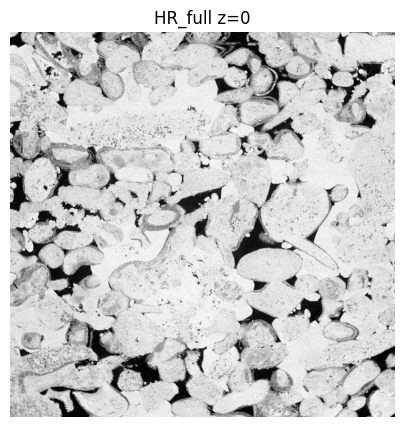

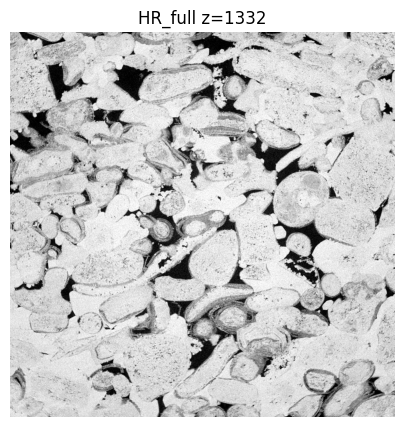

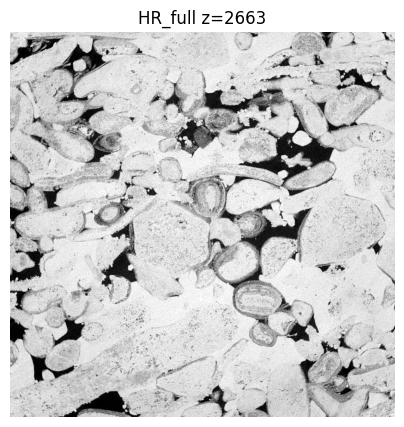

In [4]:
import h5py
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# УКАЖИ свои файлы (битую часть просто не включай)
parts = [
    r"C:\MEC_ILS\mat_volumes_ILS\ILS1.mat",
    r"C:\MEC_ILS\mat_volumes_ILS\ILS2.mat",
    r"C:\MEC_ILS\mat_volumes_ILS\ILS3.mat",
    # r"C:\MEC_ILS\mat_volumes_ILS\ILS4.mat",  # битый — пропускаем
]

def get_single_dataset_key(f: h5py.File) -> str:
    # ищем dataset верхнего уровня: l1/l2/l3/l4/HR/LR/tomo/data/vol
    for k in ("l1","l2","l3","l4","HR","LR","tomo","data","vol"):
        if k in f and isinstance(f[k], h5py.Dataset):
            return k
    # если нет — берем первый dataset где угодно
    for k, v in f.items():
        if isinstance(v, h5py.Dataset):
            return k
    # рекурсивный обход (редко нужно)
    def walk(g):
        for kk, vv in g.items():
            if isinstance(vv, h5py.Dataset):
                return g.name.strip("/") + "/" + kk if g.name != "/" else kk
            if isinstance(vv, h5py.Group):
                r = walk(vv)
                if r: return r
        return None
    key = walk(f)
    if not key:
        raise KeyError("Не найден dataset в файле")
    return key

# 1) Читаем все части полностью (в RAM) и склеиваем по оси Z (axis=0)
arrs = []
keys = []
for p in parts:
    with h5py.File(p, "r") as f:
        key = get_single_dataset_key(f)
        keys.append(key)
        arr = f[key][...]           # uint16, shape=(Z,Y,X) = (888,1520,1520)
        arrs.append(arr)

# Проверка согласованности X,Y
H, W = arrs[0].shape[1:]
assert all(a.shape[1:] == (H, W) for a in arrs), "XY-формы частей не совпадают"

HR_full = np.concatenate(arrs, axis=0)   # <-- ZYX: конкат по Z
print("keys:", keys)
print("HR_full:", HR_full.shape, HR_full.dtype)  # ожидаемо (888*n, 1520, 1520)

# 2) Быстрая визуальная проверка нескольких срезов
def win(x, lo=1, hi=99):
    vmin, vmax = np.percentile(x, (lo, hi))
    if vmax <= vmin: vmax = vmin + 1
    return float(vmin), float(vmax)

for z in [0, HR_full.shape[0]//2, HR_full.shape[0]-1]:
    sl = HR_full[z]
    vmin, vmax = win(sl)
    plt.figure(figsize=(5,5))
    plt.imshow(sl, cmap="gray", vmin=vmin, vmax=vmax)
    plt.title(f"HR_full z={z}")
    plt.axis("off")
    plt.show()

In [8]:
import h5py, numpy as np

# --- 1) утилиты ---

def get_single_dataset_key(f: h5py.File) -> str:
    for k in ("LR","HR","l1","l2","l3","l4","tomo","data","vol"):
        if k in f and isinstance(f[k], h5py.Dataset):
            return k
    for k, v in f.items():
        if isinstance(v, h5py.Dataset):
            return k
    # рекурсивно
    def walk(g):
        for kk, vv in g.items():
            if isinstance(vv, h5py.Dataset):
                return (g.name.strip("/") + "/" + kk) if g.name != "/" else kk
            if isinstance(vv, h5py.Group):
                r = walk(vv)
                if r: return r
        return None
    key = walk(f)
    if not key:
        raise KeyError("Dataset not found")
    return key

def guess_axes_zyx_or_yxz(shape):
    """Возвращает ('ZYX', z_axis) или ('YXZ', z_axis)."""
    # Если первый размер сильно меньше/больше двух других — скорее это Z
    if shape[0] != shape[1] or shape[0] != shape[2]:
        # Часто Z << XY → Z как первая или последняя ось
        if shape[0] < shape[1] and shape[0] < shape[2]:
            return ("ZYX", 0)
        if shape[2] < shape[0] and shape[2] < shape[1]:
            return ("YXZ", 2)
    # Эвристика: большинство processed-файлов MRCCM используют (Z,Y,X) или (Y,X,Z)
    # Если формы в HR_full уже известны как ZYX, примем и для LR ZYX по умолчанию:
    return ("ZYX", 0)

def lr_info(lr_mat_path):
    with h5py.File(lr_mat_path, "r") as f:
        key = get_single_dataset_key(f)
        d = f[key]
        shape = tuple(d.shape)
        dtype = d.dtype
    axes_tag, z_axis = guess_axes_zyx_or_yxz(shape)
    # Возвращаем ключ и порядок осей
    return {"path": lr_mat_path, "key": key, "shape": shape, "dtype": str(dtype),
            "axes": axes_tag, "z_axis": z_axis}

def check_lr_vs_hr(HR_full: np.ndarray, lr_mat_path: str):
    lr = lr_info(lr_mat_path)
    print(f"LR key={lr['key']} shape={lr['shape']} dtype={lr['dtype']} axes={lr['axes']} (z_axis={lr['z_axis']})")
    # Определим размеры по осям
    if lr["axes"] == "ZYX":
        Z_lr, Y_lr, X_lr = lr["shape"]
    else:
        Y_lr, X_lr, Z_lr = lr["shape"]
    Z_hr, Y_hr, X_hr = HR_full.shape  # ты собрал HR_full как (Z,Y,X)
    # Масштабы
    scale_xy = (Y_hr / Y_lr + X_hr / X_lr) / 2.0
    scale_z  = Z_hr / Z_lr
    print(f"HR_full (Z,Y,X)={HR_full.shape}")
    print(f"Scale XY ≈ {scale_xy:.3f}  |  Scale Z ≈ {scale_z:.3f}  (ожидаем ~4.0 и ~4.0)")
    # Диагностика «3 части HR vs 4 части LR»
    expect4_xy = abs(scale_xy - 4.0) < 0.2
    expect4_z  = abs(scale_z  - 4.0) < 0.2
    if expect4_xy and not expect4_z:
        print("⚠️ Разный масштаб")
        z_lr_needed = Z_hr // 4
        print(f"→ Для согласования возьми только первые {z_lr_needed} слоёв LR (из {Z_lr}).")
        print(f"   Или добавь 4-ю часть HR и пересобери HR_full до четырёх частей.")
    elif expect4_xy and expect4_z:
        print("✅ По XY и Z масштаб ≈4×. LR и HR_full покрывают один и тот же объём по глубине.")
    else:
        print("ℹ️ Масштаб отличается от 4×. Проверь, те ли файлы LR/HR используешь (Processed Volumes).")

# --- 2) вызов ---

# HR_full — твой уже собранный numpy-объём (форма (Z,Y,X))
# LR_PATH — путь к .mat с LR
# пример:
# HR_full.shape -> (2664, 1520, 1520)  # если 3 части по 888 слоёв
LR_PATH = r"C:\MEC_ILS\mat_volumes_ILS\ILS_LR.mat"  # укажи свой файл LR .mat
check_lr_vs_hr(HR_full, LR_PATH)

LR key=lo shape=(888, 380, 380) dtype=uint16 axes=ZYX (z_axis=0)
HR_full (Z,Y,X)=(2664, 1520, 1520)
Scale XY ≈ 4.000  |  Scale Z ≈ 3.000  (ожидаем ~4.0 и ~4.0)
⚠️ Разный масштаб
→ Для согласования возьми только первые 666 слоёв LR (из 888).
   Или добавь 4-ю часть HR и пересобери HR_full до четырёх частей.
